In [36]:
# General
import warnings
warnings.filterwarnings('ignore')

import time
import numpy as np
import pandas as pd
import scipy.stats as st

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preparation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
  OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, RepeatedKFold, \
  StratifiedKFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.decomposition import PCA

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# TensorFlow Models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# Linear Models
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression

# Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc,
    confusion_matrix, classification_report, roc_auc_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [9]:
# Load datasets
df_sample_submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Spaceship_Titanic_Kaggle/sample_submission.csv")
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Spaceship_Titanic_Kaggle/test.csv")
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Spaceship_Titanic_Kaggle/train.csv")

# Display training data info and check for null values
print(df_train.info(), "\n")
print("Missing values per column:\n", df_train.isnull().sum())
print(df_test.info(), "\n")
print("Missing values per column:\n", df_test.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None 

Missing values per column:
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age    

WHAT IS LEFT TO DO IS FIGURE OUT SUBMISSION. LOGISTIC REGRESSION BEAT OUT ALL MODELS.

In [10]:
# Display first few rows of training and test data
print("Training Data Preview:\n", df_train.head(), "\n")
print("Test Data Preview:\n", df_test.head(), "\n")

# Display the count of unique values in each column of the training data
unique_counts = df_train.nunique()
print("Unique value counts per column:\n", unique_counts, "\n")

Training Data Preview:
   PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        Fal

In [11]:
# Dropping 'PassengerId' and 'Name' columns as they don't contribute meaningfully to predictions
df_train = df_train.drop(['PassengerId', 'Name'], axis=1)
df_test_target = df_test['PassengerId']  # Storing 'PassengerId' from test data for future use
df_test = df_test.drop(['PassengerId', 'Name'], axis=1)

# Remaining independent columns in the dataset:
# HomePlanet, CryoSleep, Cabin, Destination, Age, VIP, RoomService,
# FoodCourt, ShoppingMall, Spa, VRDeck
# The target column 'Transported' is included in the training set only.

Correlation Matrix:
                   Age  RoomService  FoodCourt  ShoppingMall       Spa  \
Age           1.000000     0.068723   0.130421      0.033133  0.123970   
RoomService   0.068723     1.000000  -0.015889      0.054480  0.010080   
FoodCourt     0.130421    -0.015889   1.000000     -0.014228  0.221891   
ShoppingMall  0.033133     0.054480  -0.014228      1.000000  0.013879   
Spa           0.123970     0.010080   0.221891      0.013879  1.000000   
VRDeck        0.101007    -0.019581   0.227995     -0.007322  0.153821   
Transported  -0.075026    -0.244611   0.046566      0.010141 -0.221131   

                VRDeck  Transported  
Age           0.101007    -0.075026  
RoomService  -0.019581    -0.244611  
FoodCourt     0.227995     0.046566  
ShoppingMall -0.007322     0.010141  
Spa           0.153821    -0.221131  
VRDeck        1.000000    -0.207075  
Transported  -0.207075     1.000000  


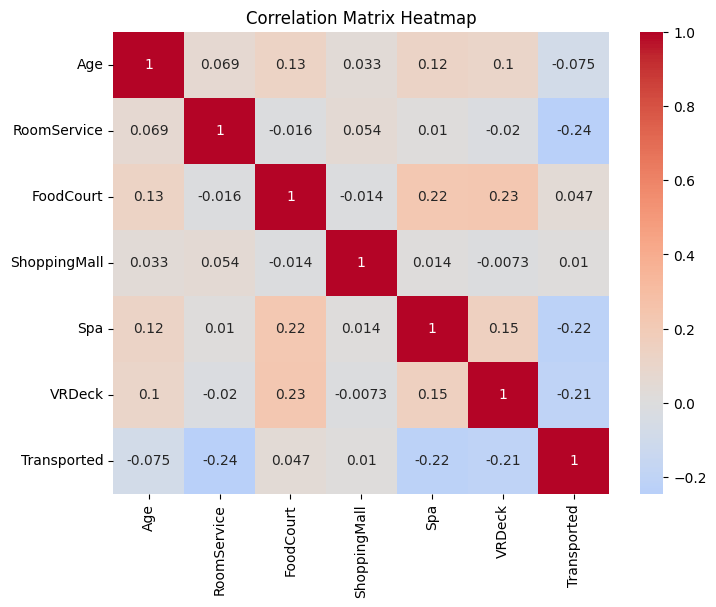

In [12]:
# Calculate the correlation matrix by dropping non-numeric columns
numeric_cols = df_train.drop(['HomePlanet', 'Destination', 'Cabin', 'CryoSleep', 'VIP'], axis=1)
correlation_matrix = numeric_cols.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

In [15]:
# Display the DataFrame to verify that the columns have been dropped
print("Training Data (after dropping columns):\n", df_train.head(), "\n")
print("Test Data (after dropping columns):\n", df_test.head(), "\n")

Training Data (after dropping columns):
   HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0     Europa     False  B/0/P  TRAPPIST-1e  39.0  False          0.0   
1      Earth     False  F/0/S  TRAPPIST-1e  24.0  False        109.0   
2     Europa     False  A/0/S  TRAPPIST-1e  58.0   True         43.0   
3     Europa     False  A/0/S  TRAPPIST-1e  33.0  False          0.0   
4      Earth     False  F/1/S  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported  
0        0.0           0.0     0.0     0.0        False  
1        9.0          25.0   549.0    44.0         True  
2     3576.0           0.0  6715.0    49.0        False  
3     1283.0         371.0  3329.0   193.0        False  
4       70.0         151.0   565.0     2.0         True   

Test Data (after dropping columns):
   HomePlanet CryoSleep  Cabin  Destination   Age    VIP  RoomService  \
0      Earth      True  G/3/S  TRAPPIST-1e  27.0  False          0.

In [16]:
# ENCODE Cabin to Port or Starboard

# Extract the side part of the 'Cabin' column (last part of the string after '/')
df_train['side'] = df_train['Cabin'].str.split('/').str[-1]
df_test['side'] = df_test['Cabin'].str.split('/').str[-1]

# Map 'P' to 'Port' and 'S' to 'Starboard'
df_train['side_full'] = df_train['side'].map({'P': 'Port', 'S': 'Starboard'})
df_test['side_full'] = df_test['side'].map({'P': 'Port', 'S': 'Starboard'})

# Drop the intermediate 'side' and 'Cabin' columns
df_train.drop(['side', 'Cabin'], axis=1, inplace=True)
df_test.drop(['side', 'Cabin'], axis=1, inplace=True)

# Display the updated DataFrames
print("Training Data (after encoding 'Cabin'):\n", df_train.head(), "\n")
print("Test Data (after encoding 'Cabin'):\n", df_test.head(), "\n")

Training Data (after encoding 'Cabin'):
   HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0     Europa     False  TRAPPIST-1e  39.0  False          0.0        0.0   
1      Earth     False  TRAPPIST-1e  24.0  False        109.0        9.0   
2     Europa     False  TRAPPIST-1e  58.0   True         43.0     3576.0   
3     Europa     False  TRAPPIST-1e  33.0  False          0.0     1283.0   
4      Earth     False  TRAPPIST-1e  16.0  False        303.0       70.0   

   ShoppingMall     Spa  VRDeck  Transported  side_full  
0           0.0     0.0     0.0        False       Port  
1          25.0   549.0    44.0         True  Starboard  
2           0.0  6715.0    49.0        False  Starboard  
3         371.0  3329.0   193.0        False  Starboard  
4         151.0   565.0     2.0         True  Starboard   

Test Data (after encoding 'Cabin'):
   HomePlanet CryoSleep  Destination   Age    VIP  RoomService  FoodCourt  \
0      Earth      True  TRAPPIST-1e  27

In [18]:
# Imputing and encoding categorical features

# One-hot encode categorical features ('HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'side_full')
# Setting drop_first=True to reduce collinearity
dummies_train = pd.get_dummies(df_train[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'side_full']], drop_first=True)
dummies_test = pd.get_dummies(df_test[['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'side_full']], drop_first=True)

# Impute missing values using KNNImputer (K-Nearest Neighbors Imputer)
knn_imputer = KNNImputer(n_neighbors=3)

# Fit and transform the data (train and test)
imputed_data_train = knn_imputer.fit_transform(dummies_train)
imputed_data_test = knn_imputer.transform(dummies_test)

# Convert the imputed data back to DataFrames
dummies_imputed_df_train = pd.DataFrame(imputed_data_train, columns=dummies_train.columns)
dummies_imputed_df_test = pd.DataFrame(imputed_data_test, columns=dummies_test.columns)

# Display info for the imputed DataFrames
print("Imputed Training Data:")
dummies_imputed_df_train.info()
print("\nImputed Test Data:")
dummies_imputed_df_test.info()

Imputed Training Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Europa          8693 non-null   float64
 1   HomePlanet_Mars            8693 non-null   float64
 2   CryoSleep_True             8693 non-null   float64
 3   Destination_PSO J318.5-22  8693 non-null   float64
 4   Destination_TRAPPIST-1e    8693 non-null   float64
 5   VIP_True                   8693 non-null   float64
 6   side_full_Starboard        8693 non-null   float64
dtypes: float64(7)
memory usage: 475.5 KB

Imputed Test Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   HomePlanet_Europa          4277 non-null   float64
 1   HomePlanet_Mars           

In [19]:
# Scaling numerical features and encoding categorical features

# Step 1: Prepare target variable from the training set
y_train = df_train['Transported']

# Step 2: Drop unnecessary columns and isolate numerical features to be scaled
X_numerical_to_be_scaled_train = df_train.drop(['Transported', 'HomePlanet', 'CryoSleep',
                                                'Destination', 'VIP', 'side_full', 'Age'], axis=1).astype('float32')
X_numerical_to_be_scaled_test = df_test.drop(['HomePlanet', 'CryoSleep',
                                              'Destination', 'VIP', 'side_full', 'Age'], axis=1).astype('float32')

# Step 3: Standardize (scale) continuous numerical features
scaler = StandardScaler()
X_numerical_scaled_train = scaler.fit_transform(X_numerical_to_be_scaled_train)
X_numerical_scaled_test = scaler.fit_transform(X_numerical_to_be_scaled_test)

# Step 4: Create DataFrame for scaled numerical data
list_numerical_features = X_numerical_to_be_scaled_train.columns
X_numerical_train = pd.DataFrame(X_numerical_scaled_train, columns=list_numerical_features)
X_numerical_test = pd.DataFrame(X_numerical_scaled_test, columns=list_numerical_features)

# Step 5: Concatenate scaled numerical features with one-hot encoded categorical features and 'Age'
X_train = pd.concat([X_numerical_train, dummies_train, df_train[['Age']]], axis=1)
X_test = pd.concat([X_numerical_test, dummies_test, df_test[['Age']]], axis=1)

print("\nX_train.info():")
X_train.info()

# Step 6: Ordinally encode certain categorical features for the model
ordinal_encoder = OrdinalEncoder()
encoded_columns = ['HomePlanet_Europa', 'HomePlanet_Mars', 'CryoSleep_True',
                   'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e',
                   'VIP_True', 'side_full_Starboard']

X_train[[f"{col}_encoded" for col in encoded_columns]] = ordinal_encoder.fit_transform(X_train[encoded_columns])
X_test[[f"{col}_encoded" for col in encoded_columns]] = ordinal_encoder.transform(X_test[encoded_columns])

# Drop original columns after encoding
X_train.drop(encoded_columns, axis=1, inplace=True)
X_test.drop(encoded_columns, axis=1, inplace=True)

# Step 7: Handle missing values by replacing NaNs with the median
columns_with_missing = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for column in columns_with_missing:
    median_value_train = X_train[column].median()
    X_train[column].fillna(median_value_train, inplace=True)

    median_value_test = X_test[column].median()
    X_test[column].fillna(median_value_test, inplace=True)

print("Training Data after replacing NaNs with median:")
X_train.info()

print("Test Data after replacing NaNs with median:")
X_test.info()


X_train.info():
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   RoomService                8512 non-null   float32
 1   FoodCourt                  8510 non-null   float32
 2   ShoppingMall               8485 non-null   float32
 3   Spa                        8510 non-null   float32
 4   VRDeck                     8505 non-null   float32
 5   HomePlanet_Europa          8693 non-null   bool   
 6   HomePlanet_Mars            8693 non-null   bool   
 7   CryoSleep_True             8693 non-null   bool   
 8   Destination_PSO J318.5-22  8693 non-null   bool   
 9   Destination_TRAPPIST-1e    8693 non-null   bool   
 10  VIP_True                   8693 non-null   bool   
 11  side_full_Starboard        8693 non-null   bool   
 12  Age                        8514 non-null   float64
dtypes: bool(7), float32(5), float64

In [23]:
# Test set preparation
# X_test is ready, as it contains only features (no target variable)

# LASSO feature selection pipeline using Logistic Regression
pipeline = Pipeline([
    # Optional: Add scaling if necessary
    # ('scaler', StandardScaler()),
    ('model', LogisticRegression(solver="liblinear", penalty="l1"))
])

# Define the parameter grid for hyperparameter tuning
param_grid = {'model__C': np.arange(0.001, 0.01, 0.001)}

# Setup GridSearchCV for hyperparameter tuning
search = GridSearchCV(pipeline, param_grid, cv=5, scoring="roc_auc", verbose=1)

# Fit the model on the training set
search.fit(X_train, y_train)

# Retrieve best hyperparameters and coefficients
print("\nBest Params:\n", search.best_params_)

# Extract coefficients and compute their importance
coefficients = search.best_estimator_.named_steps['model'].coef_
importance = np.abs(coefficients)

# Identify feature names
features = X_train.columns.tolist()

# Display importance values and identify important features
print("\nImportance values:\n", importance)
important_features = np.array(features)[importance[0] > 0]
print("Keep these features:\n", important_features)
print("Remove these features:\n", np.array(features)[importance[0] == 0])

# Keep important variables based on LASSO feature selection
importantVariablesDF = X_train[important_features]

# Uncomment to visualize the correlation heatmap
# plt.figure(figsize=(16, 16))
# heatmap = sns.heatmap(importantVariablesDF.corr(), vmin=-1, vmax=1, annot=True)
# heatmap.set_title('Correlation Heatmap', fontdict={'fontsize': 12}, pad=12)

# Calculate VIF (Variance Inflation Factor) to check for multicollinearity
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(importantVariablesDF.values, i) for i in range(importantVariablesDF.shape[1])]
vif["Features"] = importantVariablesDF.columns
print("\nVIF Factors:\n", vif.round(1))

# Final features to keep according to LASSO selection
print("\nFinal features to keep according to LASSO feature selection:\n", importantVariablesDF.columns)

# Use the selected features for both training and testing sets
final_features = importantVariablesDF.columns
X_train = X_train[final_features]
X_test = X_test[final_features]

# Inspect final feature sets
print("\nFinal X_train.info():")
X_train.info()
print("\nFinal X_test.info():")
X_test.info()

# Fit the model on the selected features
search.fit(X_train, y_train)

# Make predictions using X_test (no y_test available)
y_pred = search.predict(X_test)

# Display predictions for the test set
print("\nPredictions on test set:\n", y_pred)

Fitting 5 folds for each of 9 candidates, totalling 45 fits

Best Params:
 {'model__C': 0.009000000000000001}

Importance values:
 [[0.5230932  0.39528959 0.18181955 0.89019577 0.81307708 0.01654234
  0.91965706 1.23577046 0.14287298 0.05963734]]
Keep these features:
 ['RoomService' 'FoodCourt' 'ShoppingMall' 'Spa' 'VRDeck' 'Age'
 'HomePlanet_Europa_encoded' 'CryoSleep_True_encoded'
 'Destination_TRAPPIST-1e_encoded' 'side_full_Starboard_encoded']
Remove these features:
 []

VIF Factors:
    VIF Factor                         Features
0         1.1                      RoomService
1         1.3                        FoodCourt
2         1.1                     ShoppingMall
3         1.1                              Spa
4         1.2                           VRDeck
5         3.2                              Age
6         1.9        HomePlanet_Europa_encoded
7         1.9           CryoSleep_True_encoded
8         2.4  Destination_TRAPPIST-1e_encoded
9         1.8      side_full_Starboa

In [25]:
# Function to find the best threshold based on F1 score
def find_best_threshold(y_true, y_prob):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_f1 = 0
    best_threshold = 0

    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    return best_threshold, best_f1

# Initialize the logistic regression model
log_reg = LogisticRegression(solver='liblinear')

# Cross-validation to find the best threshold
skf = StratifiedKFold(n_splits=5)
best_thresholds = []
best_f1_scores = []
f1_scores_train = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_cv, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    log_reg.fit(X_train_cv, y_train_cv)

    # Predict probabilities on validation set
    y_prob_val = log_reg.predict_proba(X_val)[:, 1]

    # Find the best threshold for the current fold
    best_threshold, best_f1_score = find_best_threshold(y_val, y_prob_val)
    best_thresholds.append(best_threshold)
    best_f1_scores.append(best_f1_score)

    # Calculate F1 score for training set
    y_prob_train = log_reg.predict_proba(X_train_cv)[:, 1]
    f1_train = f1_score(y_train_cv, (y_prob_train >= best_threshold).astype(int))
    f1_scores_train.append(f1_train)

# Average the best thresholds and F1 scores
best_threshold_avg = np.mean(best_thresholds)
best_f1_score_avg = np.mean(best_f1_scores)

print(f'Best Average Threshold: {best_threshold_avg}')
print(f'Best Average F1 Score: {best_f1_score_avg}')

# Output training set performance metrics
average_f1_score_train = np.mean(f1_scores_train)
print(f'Average F1 Score on Training Set: {average_f1_score_train}')

# Train the model on the entire training data
log_reg.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = log_reg.predict_proba(X_test)[:, 1]

# Apply the best threshold to the test set
y_pred_final_test = (y_prob_test >= best_threshold_avg).astype(int)

# Create DataFrame for output
output_df = pd.DataFrame({
    'PassengerId': df_test_target,
    'Transported': y_pred_final_test.astype(bool)  # Convert to boolean (True/False)
})

# Save DataFrame to CSV
output_df.to_csv('predictions.csv', index=False)

# Evaluate training set performance
y_pred_final_train = (log_reg.predict_proba(X_train)[:, 1] >= best_threshold_avg).astype(int)
print("Logistic Regression Performance on Training Set:")
print(f'Accuracy: {accuracy_score(y_train, y_pred_final_train)}')
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_pred_final_train))
print('Classification Report:')
print(classification_report(y_train, y_pred_final_train))

Best Average Threshold: 0.376
Best Average F1 Score: 0.808613030158903
Average F1 Score on Training Set: 0.8085478128612372
Logistic Regression Performance on Training Set:
Accuracy: 0.7859197055101806
Confusion Matrix:
[[2902 1413]
 [ 448 3930]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.67      0.76      4315
        True       0.74      0.90      0.81      4378

    accuracy                           0.79      8693
   macro avg       0.80      0.79      0.78      8693
weighted avg       0.80      0.79      0.78      8693



In [27]:
# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Cross-validation to find the best threshold
skf = StratifiedKFold(n_splits=5)
best_thresholds = []
best_f1_scores = []
f1_scores_train = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_cv, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    rf_model.fit(X_train_cv, y_train_cv)

    # Predict probabilities on validation set
    y_prob_val = rf_model.predict_proba(X_val)[:, 1]

    # Find the best threshold for the current fold
    best_threshold, best_f1_score = find_best_threshold(y_val, y_prob_val)
    best_thresholds.append(best_threshold)
    best_f1_scores.append(best_f1_score)

    # Calculate F1 score for training set
    y_prob_train = rf_model.predict_proba(X_train_cv)[:, 1]
    f1_train = f1_score(y_train_cv, (y_prob_train >= best_threshold).astype(int))
    f1_scores_train.append(f1_train)

# Average the best thresholds and F1 scores
best_threshold_avg = np.mean(best_thresholds)
best_f1_score_avg = np.mean(best_f1_scores)

print(f'Best Average Threshold: {best_threshold_avg}')
print(f'Best Average F1 Score: {best_f1_score_avg}')

# Output training set performance metrics
average_f1_score_train = np.mean(f1_scores_train)
print(f'Average F1 Score on Training Set: {average_f1_score_train}')

# Train the model on the entire training data
rf_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = rf_model.predict_proba(X_test)[:, 1]

# Apply the best threshold to the test set
y_pred_final_test = (y_prob_test >= best_threshold_avg).astype(int)

# Create DataFrame for output
output_df = pd.DataFrame({
    'PassengerId': df_test_target,
    'Transported': y_pred_final_test.astype(bool)  # Convert to boolean (True/False)
})

# Save DataFrame to CSV
output_df.to_csv('predictions.csv', index=False)

# Evaluate training set performance
print("Random Forest Performance on Training Set:")
y_pred_final_train = (rf_model.predict_proba(X_train)[:, 1] >= best_threshold_avg).astype(int)
print(f'Accuracy: {accuracy_score(y_train, y_pred_final_train)}')
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_pred_final_train))
print('Classification Report:')
print(classification_report(y_train, y_pred_final_train))

Best Average Threshold: 0.38
Best Average F1 Score: 0.8008522459557197
Average F1 Score on Training Set: 0.9306879091210722
Random Forest Performance on Training Set:
Accuracy: 0.9243069136086507
Confusion Matrix:
[[3686  629]
 [  29 4349]]
Classification Report:
              precision    recall  f1-score   support

       False       0.99      0.85      0.92      4315
        True       0.87      0.99      0.93      4378

    accuracy                           0.92      8693
   macro avg       0.93      0.92      0.92      8693
weighted avg       0.93      0.92      0.92      8693



In [50]:
# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
)

# Cross-validation to find the best threshold
skf = StratifiedKFold(n_splits=5)
best_thresholds = []
best_f1_scores = []
f1_scores_train = []

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_cv, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Train the model
    xgb_model.fit(X_train_cv, y_train_cv)

    # Predict probabilities on validation set
    y_prob_val = xgb_model.predict_proba(X_val)[:, 1]

    # Find the best threshold for the current fold
    best_threshold, best_f1_score = find_best_threshold(y_val, y_prob_val)
    best_thresholds.append(best_threshold)
    best_f1_scores.append(best_f1_score)

    # Calculate F1 score for training set
    y_prob_train = xgb_model.predict_proba(X_train_cv)[:, 1]
    f1_train = f1_score(y_train_cv, (y_prob_train >= best_threshold).astype(int))
    f1_scores_train.append(f1_train)

# Average the best thresholds and F1 scores
best_threshold_avg = np.mean(best_thresholds)
best_f1_score_avg = np.mean(best_f1_scores)

print(f'Best Average Threshold: {best_threshold_avg}')
print(f'Best Average F1 Score: {best_f1_score_avg}')

# Output training set performance metrics
average_f1_score_train = np.mean(f1_scores_train)
print(f'Average F1 Score on Training Set: {average_f1_score_train}')

# Train the model on the entire training data
xgb_model.fit(X_train, y_train)

# Predict probabilities on the test set
y_prob_test = xgb_model.predict_proba(X_test)[:, 1]

# Apply the best threshold to the test set
y_pred_final_test = (y_prob_test >= best_threshold_avg).astype(int)

# Create DataFrame for output
output_df = pd.DataFrame({
    'PassengerId': df_test_target,  # Assuming df_test_target has Passenger IDs
    'Transported': y_pred_final_test.astype(bool)  # Convert to boolean (True/False)
})

# Save DataFrame to CSV
output_df.to_csv('predictions.csv', index=False)

# Evaluate training set performance
y_pred_final_train = (xgb_model.predict_proba(X_train)[:, 1] >= best_threshold_avg).astype(int)

print("XGBoost Performance on Training Set:")
print(f'Accuracy: {accuracy_score(y_train, y_pred_final_train)}')
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_pred_final_train))
print('Classification Report:')
print(classification_report(y_train, y_pred_final_train))

Best Average Threshold: 0.418
Best Average F1 Score: 0.8092055441601186
Average F1 Score on Training Set: 0.8376539395513098
XGBoost Performance on Training Set:
Accuracy: 0.8215805820775336
Confusion Matrix:
[[3202 1113]
 [ 438 3940]]
Classification Report:
              precision    recall  f1-score   support

       False       0.88      0.74      0.81      4315
        True       0.78      0.90      0.84      4378

    accuracy                           0.82      8693
   macro avg       0.83      0.82      0.82      8693
weighted avg       0.83      0.82      0.82      8693



In [31]:
# Initialize lists for cross-validation results
best_thresholds = []
best_f1_scores = []
f1_scores_train = []

# Cross-validation setup
skf = StratifiedKFold(n_splits=5)

for train_idx, val_idx in skf.split(X_train, y_train):
    X_train_cv, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_train_cv, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # Build the neural network model
    model = Sequential()
    model.add(Dense(units=64, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(units=32, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Set up Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train_cv, y_train_cv, epochs=100, batch_size=32, validation_split=0.2,
              callbacks=[early_stopping], verbose=0)

    # Predict probabilities on validation set
    y_prob_val = model.predict(X_val).flatten()

    # Find the best threshold for the current fold
    best_threshold, best_f1_score = find_best_threshold(y_val, y_prob_val)
    best_thresholds.append(best_threshold)
    best_f1_scores.append(best_f1_score)

    # Calculate F1 score for training set
    y_prob_train = model.predict(X_train_cv).flatten()
    f1_train = f1_score(y_train_cv, (y_prob_train >= best_threshold).astype(int))
    f1_scores_train.append(f1_train)

# Average the best thresholds and F1 scores
best_threshold_avg = np.mean(best_thresholds)
best_f1_score_avg = np.mean(best_f1_scores)

print(f'Best Average Threshold: {best_threshold_avg}')
print(f'Best Average F1 Score: {best_f1_score_avg}')

# Output training set performance metrics
average_f1_score_train = np.mean(f1_scores_train)
print(f'Average F1 Score on Training Set: {average_f1_score_train}')

# Train the model on the entire training data
model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Predict probabilities on the test set
y_prob_test = model.predict(X_test).flatten()

# Apply the best threshold to the test set
y_pred_final_test = (y_prob_test >= best_threshold_avg).astype(int)

# Create DataFrame for output
output_df = pd.DataFrame({
    'PassengerId': df_test_target,  # Assuming df_test_target has Passenger IDs
    'Transported': y_pred_final_test.astype(bool)  # Convert to boolean (True/False)
})

# Save DataFrame to CSV
output_df.to_csv('predictions.csv', index=False)

# Evaluate training set performance
print("Neural Network Performance on Training Set:")
y_pred_final_train = (model.predict(X_train).flatten() >= best_threshold_avg).astype(int)
print(f'Accuracy: {accuracy_score(y_train, y_pred_final_train)}')
print('Confusion Matrix:')
print(confusion_matrix(y_train, y_pred_final_train))
print('Classification Report:')
print(classification_report(y_train, y_pred_final_train))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Best Average Threshold: 0.364
Best Average F1 Score: 0.8114804048817298
Average F1 Score on Training Set: 0.8081043563967579
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Neural Network Performance on Training Set:
272/272 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Accuracy: 0.7947774071091683
Confusion Matrix:
[[2986 1329]
 [ 455 3923]]
Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.69      0.77      4315
        True       0.75      0.90      0.81      4378

    accuracy                           0.79      8693
   macro avg       0.81      0.79      0.79      8693
weighted avg       0.81      0.79      0.79      8693

